# Single Table Analysis Template

In [ ]:
# Removes lint errors from VS Code
from typing import Dict, TYPE_CHECKING, Tuple, List

if TYPE_CHECKING:
    import kedro

    catalog: kedro.io.data_catalog.DataCatalog
    session: kedro.framework.session.session.KedroSession
    pipelines: Dict[str, kedro.pipeline.pipeline.Pipeline]

In [ ]:
import os

VIEW = os.getenv("DATASET_VIEW") or "tab_adult"
TABLE = os.getenv("DATASET_TABLE") or "table"
ALG = os.getenv("SYNTH_ALG") or "ref"

import numpy as np
import pandas as pd

wrk: pd.DataFrame = catalog.load(f"{VIEW}.wrk.{TABLE}")
alg: pd.DataFrame = catalog.load(f"{VIEW}.{ALG}.{TABLE}")

from pasteur.metadata import Metadata
meta = catalog.load(f"params:{VIEW}.metadata")
meta = Metadata(meta, wrk).get_table(TABLE)

2000-01-01 00:00:00,000 - kedro.io.data_catalog - INFO - Loading data from `tab_adult.wrk.table` (ParquetDataSet)...
2000-01-01 00:00:00,000 - kedro.io.data_catalog - INFO - Loading data from `tab_adult.ref.table` (ParquetDataSet)...
2000-01-01 00:00:00,000 - kedro.io.data_catalog - INFO - Loading data from `params:tab_adult.metadata` (MemoryDataSet)...


In [ ]:
wrk.head()

,id,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
1,6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica
2,7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
3,9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States
4,10,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States


In [ ]:
wrk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13024 entries, 0 to 13023
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              13024 non-null  int64   
 1   age             13024 non-null  int32   
 2   workclass       13024 non-null  category
 3   fnlwgt          13024 non-null  int32   
 4   education       13024 non-null  category
 5   education-num   13024 non-null  int32   
 6   marital-status  13024 non-null  category
 7   occupation      13024 non-null  category
 8   relationship    13024 non-null  category
 9   race            13024 non-null  category
 10  sex             13024 non-null  category
 11  capital-gain    13024 non-null  int32   
 12  capital-loss    13024 non-null  int32   
 13  hours-per-week  13024 non-null  int32   
 14  native-country  13024 non-null  category
dtypes: category(8), int32(6), int64(1)
memory usage: 614.5 KB


In [ ]:
# Plotting
%matplotlib inline

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

plt.style.use("./utils/light.mplstyle")
plt.rcParams['figure.figsize'] = [9, 6]
# plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [ ]:
from pandas.api.types import (
    is_datetime64_any_dtype as is_datetime,
    is_timedelta64_dtype as is_timedelta,
)

def gen_freq(a, b, cols, is_cat=None, fillna=1e-6, bins=32):
    if isinstance(cols, str):
        cols = [cols]
    if isinstance(is_cat, bool):
        is_cat = [is_cat]

    # Shallow copy a, b and only keep cols
    # FIXME: stop dropping NAs
    a, b = a[cols].dropna(), b[cols].dropna()

    # Convert any continuous variables to discrete
    if is_cat is not None and not all(is_cat):
        for col, cat in zip(cols, is_cat):
            if cat:
                continue

            if is_datetime(a[col]):
                c, d = a[col].dt.day_of_year, b[col].dt.day_of_year
            else:
                c, d = pd.to_numeric(a[col]), pd.to_numeric(b[col])

            col_bins = np.histogram_bin_edges(c, bins=bins).astype(np.float32)
            a[col] = np.digitize(c, col_bins)
            b[col] = np.digitize(d, col_bins)

    ## Calculate frequencies of discrete variables
    a, b = a.value_counts(), b.value_counts()
    c = pd.concat([a, b], axis=1)
    c = c / c.sum()
    c = c.fillna(value=fillna)
    c[c == 0] = fillna
    c = c / c.sum()
    return c.iloc[:, 0], c.iloc[:, 1]


In [ ]:
from scipy.stats import chisquare

res = []
for col in meta.columns:
    k, j = gen_freq(wrk, alg, col, meta[col].is_cat())
    chi, p = chisquare(k, j)
    # print(f"{name:12}.{col:20}: X^2={chi:3.3f} p={100*p:7.3f}%")
    res.append([meta[col].type, col, chi, p])

res = pd.DataFrame(res, columns=["type", "col", "X^2", "p"])
res.set_index(keys=["type", "col"]).sort_index().style.background_gradient(axis=0)


In [ ]:
from scipy.stats import ks_2samp

res = []
for col in meta.cols:
    if meta[col].is_cat():
        continue
    c, d = wrk[col].dropna(), alg[col].dropna()
    ks, p = ks_2samp(c, d)
    res.append([meta[col].type, col, ks, p])

res = pd.DataFrame(res, columns=["type", "col", "K-S", "p"])
res.set_index(keys=["type", "col"]).style.background_gradient(axis=0)


In [ ]:
from scipy.special import rel_entr

res = []
cols = meta.cols
for i, col_i in enumerate(cols):
    if meta[col_i].is_id():
        continue
    cat_i = meta[col_i].is_cat()

    for col_j in cols: #[i + 1 :]:
        if meta[col_j].is_id():
            continue
        cat_j = meta[col_j].is_cat()

        if col_i == col_j:
            k, j = gen_freq(wrk, alg, [col_i], [cat_i])
        else:
            k, j = gen_freq(wrk, alg, [col_i, col_j], [cat_i, cat_j])
            
        kl = rel_entr(k, j).sum()
        kl_norm = 1 / (1 + kl)
        res.append([meta[col_i].type, col_i, meta[col_j].type, col_j, kl, kl_norm, len(k), cat_i, cat_j])

res = pd.DataFrame(
    res,
    columns=[
        "type_i",
        "col_i",
        "type_j",
        "col_j",
        "kl",
        "kl_norm",
        "mlen",
        "cat_i",
        "cat_j",
    ],
)
res.head()

,type_i,col_i,type_j,col_j,kl,kl_norm,mlen,cat_i,cat_j
0,numerical,age,numerical,age,0.002641,0.997366,33,False,False
1,numerical,age,categorical,workclass,0.019255,0.981109,220,False,True
2,numerical,age,numerical,fnlwgt,0.048356,0.953874,429,False,False
3,numerical,age,categorical,education,0.049533,0.952805,456,False,True
4,numerical,age,numerical,education-num,0.049533,0.952805,456,False,False


In [ ]:
def mk_kl_plot(filter=None, val="kl_norm"):
    # idx_tuples = []
    # for table in reversed(tables):
    #     a, _ = tables[table]
    #     for col in sorted(a.keys()):
    #         if is_categorical(table, col):
    #             idx_tuples.append((table, col))

    # idx = pd.MultiIndex.from_tuples(idx_tuples, names=['table_i', 'col_i'])
    # cols = pd.MultiIndex.from_tuples(reversed(idx_tuples), names=['table_j', 'col_j'])

    pt = res[filter] if filter is not None else res
    pt = pt.pivot_table(
        values=val, index=["type_i", "col_i"], columns=["type_j", "col_j"]
    )

    # Try to tweak colormap
    vmin = vmax = None
    # match val:
    #     case "kl_norm":
    #         vmin = 0.996
    #     case "kl":
    #         vmax = 0.04
    #     case "mlen":
    #         vmax = 100

    # pt = pt.reindex(index=idx, columns=cols)
    pt = pt.style.background_gradient(axis=None, vmin=vmin, vmax=vmax).applymap(
        lambda x: "color: transparent; background-color: transparent"
        if pd.isnull(x)
        else ""
    )

    return pt


In [ ]:
mk_kl_plot()

In [ ]:
def mk_kl_plot(filter=None, val="kl_norm"):
    # idx_tuples = []
    # for table in reversed(tables):
    #     a, _ = tables[table]
    #     for col in sorted(a.keys()):
    #         if is_categorical(table, col):
    #             idx_tuples.append((table, col))

    # idx = pd.MultiIndex.from_tuples(idx_tuples, names=['table_i', 'col_i'])
    # cols = pd.MultiIndex.from_tuples(reversed(idx_tuples), names=['table_j', 'col_j'])

    pt = res[filter] if filter is not None else res
    pt = pt.pivot_table(
        values=val, index=["type_i", "col_i"], columns=["type_j", "col_j"]
    )

    # Try to tweak colormap
    vmin = vmax = None
    # match val:
    #     case "kl_norm":
    #         vmin = 0.996
    #     case "kl":
    #         vmax = 0.04
    #     case "mlen":
    #         vmax = 100

    # pt = pt.reindex(index=idx, columns=cols)
    pt = pt.style.background_gradient(axis=None, vmin=vmin, vmax=vmax).applymap(
        lambda x: "color: transparent; background-color: transparent"
        if pd.isnull(x)
        else ""
    )

    return pt


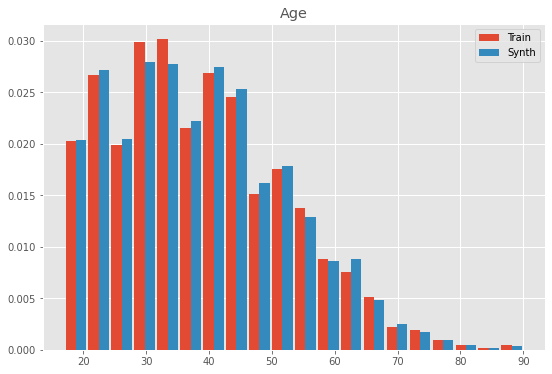

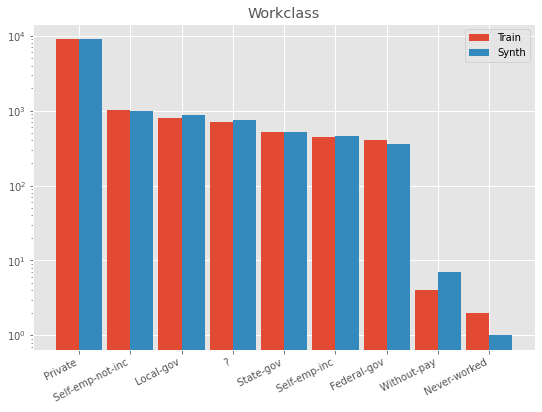

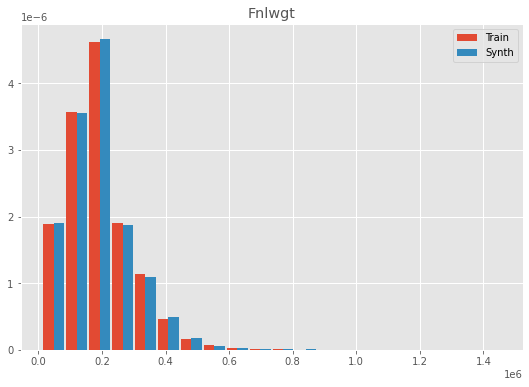

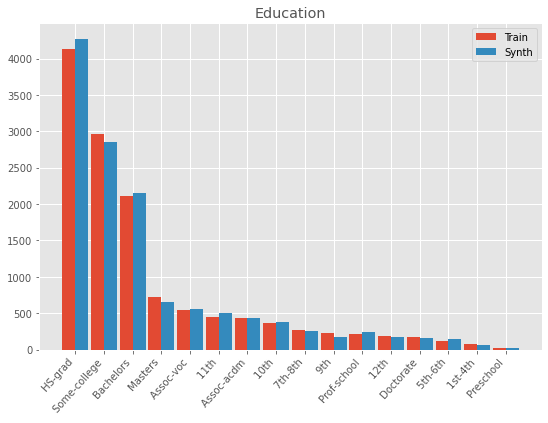

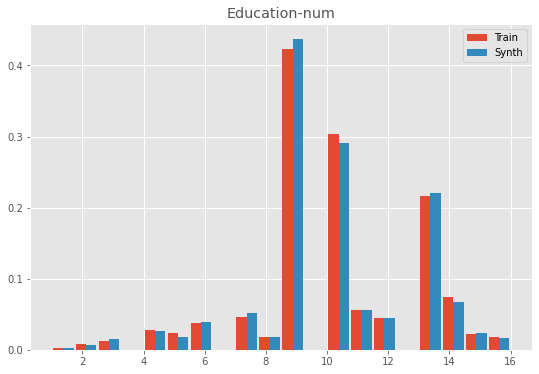

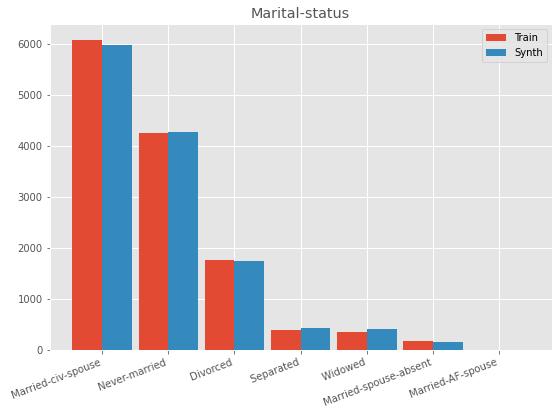

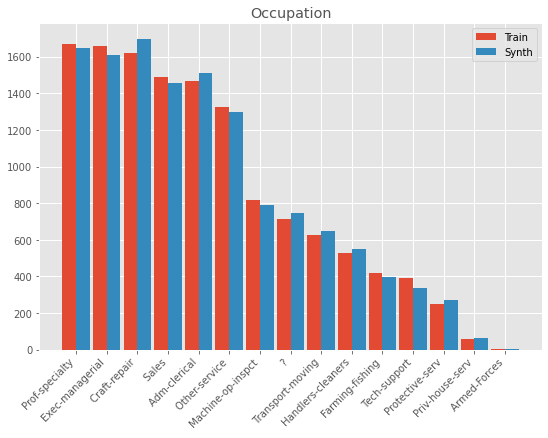

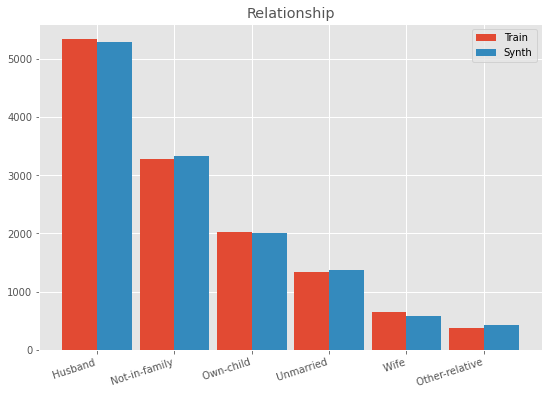

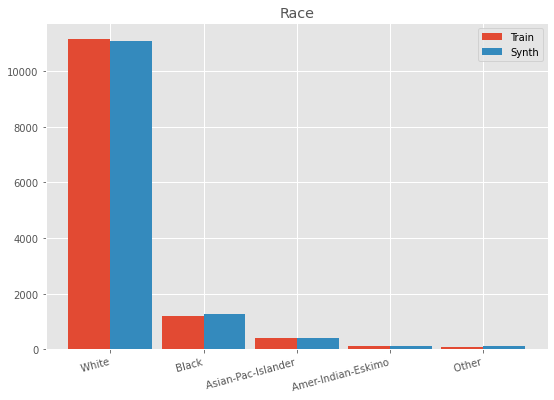

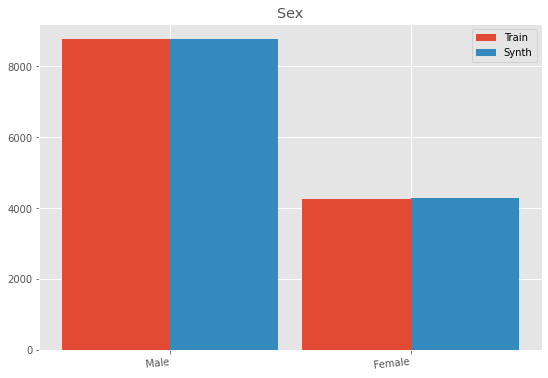

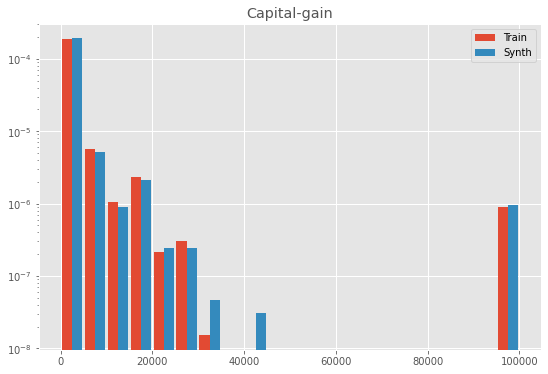

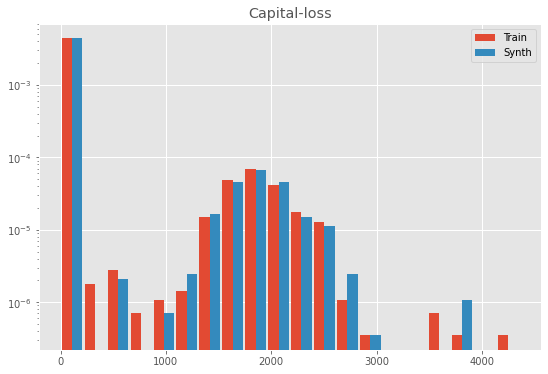

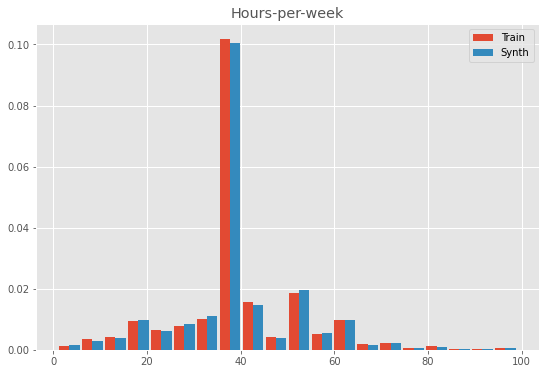

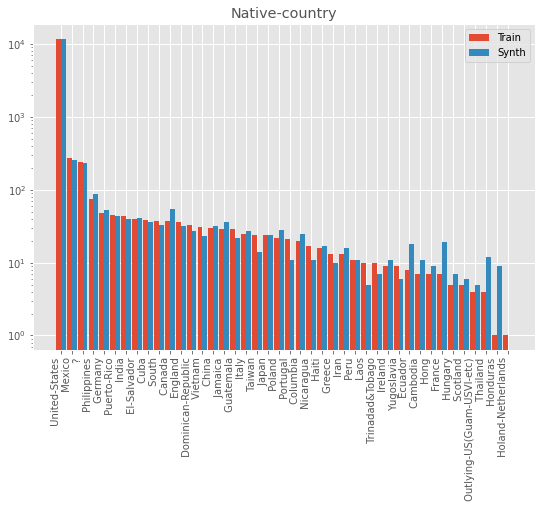

In [ ]:
for col in meta.cols:
    fig, ax = plt.subplots()

    if meta[col].is_cat():
        c_wrk = wrk.value_counts(col)
        c_alg = alg.value_counts(col)
        c = pd.concat([c_wrk, c_alg], axis=1)
        c_wrk, c_alg = c.iloc[:, 0], c.iloc[:, 1]
        keys = list(c_wrk.keys())
        ax.bar(keys, list(c_wrk.values), width=-.45, align="edge", label="Train")
        ax.bar(keys, list(c_alg.values), width=.45, align="edge", label="Synth")
        plt.setp(ax.get_xticklabels(), rotation=min(3*len(keys), 90), horizontalalignment='right')
        # ax.yaxis.set_major_locator(ticker.MultipleLocator(50000))
        # ax.yaxis.set_minor_locator(ticker.MultipleLocator(25000))
        # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '%dk' % (x / 1000) if x else '0'))
        # ax.set_ylim([0, 225000])
    else:
        col_bins = np.histogram_bin_edges(wrk[col], bins=20).astype(np.float32)
        ax.hist([wrk[col], alg[col]], bins=col_bins, density=True, rwidth=0.9, label=["Train", "Synth"])
        # ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
        if meta[col].metrics.x_log:
            ax.set_xscale('log') 
    
    metrics = meta[col].metrics

    if metrics.y_log:
        ax.set_yscale('log')
    ax.set_title(col.capitalize())
    ax.set_xlim([metrics.x_min, metrics.x_max])
    ax.set_ylim([metrics.y_min, metrics.y_max])
    ax.legend()
    


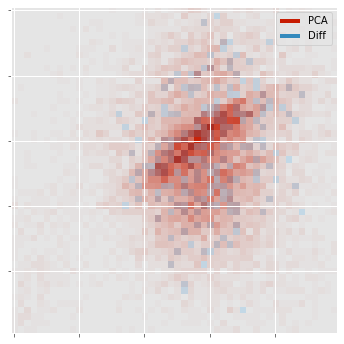

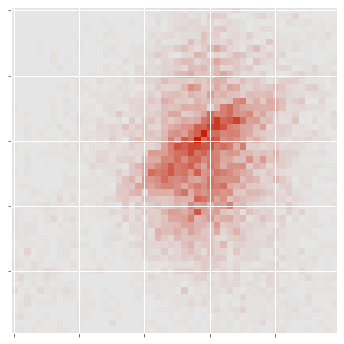

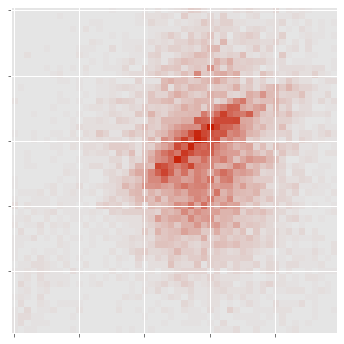

In [ ]:
from sklearn.decomposition import PCA

numerical = [name for name, c in meta.cols.items() if c.type == "numerical"]

n_wrk = wrk[numerical]
n_alg = alg[numerical]

std = np.std(n_wrk, axis=0)
mean = np.std(n_alg, axis=0)

n_wrk = (n_wrk - mean) / std
n_alg = (n_alg - mean) / std

pca = PCA(2)
pca.fit(n_wrk)
pca_wrk = pca.transform(n_wrk)
pca_alg = pca.transform(n_alg)

lims = np.percentile(pca_wrk, [3, 97], axis=0) 

def f_lims(data, buffer=0.1):
    l_min, l_max = data
    l_dev = l_max - l_min
    return l_min - buffer*l_dev, l_max + buffer*l_dev

x_min, x_max = f_lims(lims[:, 0])
y_min, y_max = f_lims(lims[:, 1])

bins = 50
H_wrk, xedges, yedges = np.histogram2d(pca_wrk[:, 0], pca_wrk[:, 1], range=[[x_min, x_max], [y_min, y_max]], bins=bins)
H_alg, _, _ = np.histogram2d(pca_alg[:, 0], pca_alg[:, 1], bins=[xedges, yedges])

h_diff = np.abs(H_wrk - H_alg)
h_diff /= np.max(H_alg)
h_wrk = H_wrk / np.max(H_wrk)
h_alg = H_alg / np.max(H_alg)

width, height = H_wrk.shape
img_wrk = np.zeros((width, height, 4), dtype="int32")
img_alg = np.zeros((width, height, 4), dtype="int32")
img_dff = np.zeros((width, height, 4), dtype="int32")

for i in range(width):
    for j in range(height):
        img_wrk[i, j, :] = (255*np.array((0.78, 0.11, 0.008, h_wrk[i,j]))).astype('int32')
        img_alg[i, j, :] = (255*np.array((0.78, 0.11, 0.008, h_alg[i,j]))).astype('int32')
        img_dff[i, j, :] = (255*np.array((0.008, 0.58, 0.933, 0.15 if h_diff[i,j] > 0.1 else 0))).astype('int32')

fig, ax = plt.subplots()
ax.imshow(img_alg, interpolation="nearest")
ax.imshow(img_dff, interpolation="nearest")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="#c71c02", lw=4),
                Line2D([0], [0], color="#348abd", lw=4)]

ax.legend(custom_lines, ['PCA', "Diff"])
ax.set_xticklabels([])
ax.set_yticklabels([])

fig, ax = plt.subplots()
ax.imshow(img_wrk, interpolation="nearest")
ax.set_xticklabels([])
ax.set_yticklabels([])
fig, ax = plt.subplots()
ax.imshow(img_alg, interpolation="nearest")
ax.set_xticklabels([])
ax.set_yticklabels([]);

# l_num = 5
# x_pos = np.linspace(0, img.shape[0], l_num+2)[1:-1]
# x_labels = np.linspace(x_min, x_max, l_num+2)[1:-1].astype('int32')
# ax.set_xticks(x_pos, x_labels)

# y_pos = np.linspace(0, img.shape[0], l_num+2)[1:-1]
# y_labels = np.linspace(y_min, y_max, l_num+2)[1:-1].astype('int32')
# ax.set_yticks(y_pos, y_labels)

ax.set_xticklabels([])
ax.set_yticklabels([]);
# ax.grid(False)